# Simulação de offset zero
CC BY : https://creativecommons.org/licenses/by/4.0/deed.pt_BR

Thiago Pacheco Carneiro

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union

In [18]:
class Camada():
    def __init__(self, profundidade: float, velocidade: float, densidade: float) -> None:
        self.prof = profundidade
        self.vel = velocidade
        self.rho = densidade
        self.imped = velocidade*densidade # impedância
        self.tempo = profundidade/velocidade

In [19]:
class Modelo():
    def __init__(self, camadas: list[Camada]) -> None:
        self.camadas = list(camadas)
        r_ida = []
        t_ida = []
        r_vinda = []
        t_vinda = []
        for i in range(len(camadas)-1):
            z1 = camadas[i].imped
            z2 = camadas[i+1].imped
            r_i = (z2 - z1) / (z2 + z1)
            t_i = 2 * z1 / (z2 + z1)
            r_ida.append(r_i)
            t_ida.append(t_i)
            r_v = (z1 - z2) / (z2 + z1)
            t_v = 2 * z2 / (z2 + z1)
            r_vinda.append(r_v)
            t_vinda.append(t_v)
        self.reflex_ida = r_ida
        self.transm_ida = t_ida
        self.reflex_vinda = r_vinda
        self.transm_vinda = t_vinda
    def obter_pulsos(self, t_max: int = 3) -> pd.DataFrame:
        p = self.pulsar(i = 0, t = 0., pulso=1., sentido=1, t_max = t_max)
        return pd.DataFrame(p).groupby('instante').sum()
    def obter_pulsos_limpo(self, t_max: int = 3) -> pd.DataFrame:
        p = self.pulsar_limpo(i = 0, t = 0., pulso=1., sentido=1, t_max = t_max)
        return pd.DataFrame(p).groupby('instante').sum()
    def pulsar(self, i: int, t: float, pulso: float, sentido: int, t_max: int) -> Union[list[dict[str,float]],None]:
        t_i = t + self.camadas[i].tempo
        ida = vinda = None
        pulso *= (1-5e-4)**self.camadas[i].prof     #dissipação com a distância
        if t_i > t_max or abs(pulso)<1e-6:
            return None
        if i == 0 and sentido == -1:
            return [{'instante':t_i, 'pulso': pulso}]
        if sentido == 1 and i<len(self.reflex_ida):
            ida = self.pulsar(i + 1, t_i, pulso * self.transm_ida[i], 1, t_max)
            vinda = self.pulsar(i, t_i, pulso * self.reflex_ida[i], -1, t_max)
        if sentido == -1:
            vinda = self.pulsar(i - 1, t_i, pulso * self.transm_vinda[i - 1], -1, t_max)
            ida = self.pulsar(i, t_i, pulso * self.reflex_vinda[i - 1], 1, t_max)
        retorno = []
        if ida is not None:
            retorno += ida
        if vinda is not None:
            retorno += vinda
        return retorno
    def pulsar_limpo(self, i: int, t: float, pulso: float, sentido: int, t_max: int) -> Union[list[dict[str,float]],None]:
        t_i = t + self.camadas[i].tempo
        ida = vinda = None
        pulso *= (1-5e-4)**self.camadas[i].prof     #dissipação com a distância
        if t_i > t_max or abs(pulso)<1e-6:
            return None
        if i == 0 and sentido == -1:
            return [{'instante':t_i, 'pulso': pulso}]
        if sentido == 1 and i<len(self.reflex_ida):
            ida = self.pulsar(i + 1, t_i, pulso * self.transm_ida[i], 1, t_max)
            vinda = self.pulsar(i, t_i, pulso * self.reflex_ida[i], -1, t_max)
        if sentido == -1:
            vinda = self.pulsar(i - 1, t_i, pulso * self.transm_vinda[i - 1], -1, t_max)
        retorno = []
        if ida is not None:
            retorno += ida
        if vinda is not None:
            retorno += vinda
        return retorno

In [20]:
class Modelo2D():
    def __init__(self, camadas2D: list[list[Camada]]) -> None:
        cols = []
        nz = 0
        for col in camadas2D:
            m_i = Modelo(col)
            cols.append(m_i)
            prof_i = np.sum([camada.prof for camada in col])
            nz = prof_i if prof_i > nz else nz
        self.colunas=cols
        self.nz = nz
        self.nx = len(camadas2D)
    def rasterizar(self) -> dict[str,np.ndarray]:
        v2D = np.zeros((self.nx,self.nz))
        rho2D = np.zeros((self.nx,self.nz))
        for x in range(self.nx):
            col = self.colunas[x]
            z = 0
            for camada in col.camadas:
                z_ = z+camada.prof
                v2D[x,z:z_]=camada.vel
                rho2D[x,z:z_]=camada.rho
                z = z_
        return {'velocidades': v2D.T,
                'densidades': rho2D.T}
    def adquirir_sismica(self, t_max: int = 3, res: int = 1e2) -> np.ndarray:
        sis = np.zeros((int(self.nx),int(t_max*res)))
        for x in range(self.nx):
            col = self.colunas[x]
            pulsos = col.obter_pulsos(t_max)
            pulsos['z']=(pulsos.index*res).astype(int)
            pulsos_z = pulsos.groupby('z').sum()
            for z, linha in pulsos_z.iterrows():
                sis[x,z] += linha['pulso']
        return sis.T
    def adquirir_sismica_limpo(self, t_max: int = 3, res: int = 1e2) -> np.ndarray:
        sis = np.zeros((int(self.nx),int(t_max*res)))
        for x in range(self.nx):
            col = self.colunas[x]
            pulsos = col.obter_pulsos_limpo(t_max)
            pulsos['z']=(pulsos.index*res).astype(int)
            pulsos_z = pulsos.groupby('z').sum()
            for z, linha in pulsos_z.iterrows():
                sis[x,z] += linha['pulso']
        return sis.T
    def plot(self, t_max = 3) -> None:
        rast = self.rasterizar()
        v2D = rast['velocidades']
        rho2D = rast['densidades']
        sis = self.adquirir_sismica(t_max=t_max)
        sis_limpo = self.adquirir_sismica_limpo(t_max=t_max)
        fig, ax = plt.subplots(1,4, figsize=(10,10))
        ax[0].set_title('Velocidade')
        ax[0].set_xlabel('Distância (m)')
        ax[0].set_ylabel('Profundidade (m)')
        ax[1].set_title('Densidade')
        ax[1].set_xlabel('Distância (m)')
        ax[1].set_ylabel('Profundidade (m)')
        ax[2].set_title('Sismograma')
        ax[2].set_xlabel('Distância (m)')
        ax[2].set_ylabel('Tempo (s)')
        ax[3].set_title('Sismograma "limpo"')
        ax[3].set_xlabel('Distância (m)')
        ax[3].set_ylabel('Tempo (s)')
        ax[0].imshow(v2D, cmap='binary', aspect='auto')
        ax[1].imshow(rho2D, cmap='binary', aspect='auto')
        ax[2].imshow(sis, cmap='binary', aspect='auto',vmin=-1e-2, vmax=1e-2, extent=[0,self.nx,t_max,0])
        ax[3].imshow(sis_limpo, cmap='binary', aspect='auto',vmin=-1e-2, vmax=1e-2, extent=[0,self.nx,t_max,0])

        plt.tight_layout()

In [21]:
class ModeloParalelas(Modelo2D):
    def __init__(self, v = (1500,2800,4500,3200), rho = (1, 2, 2.16, 2.6)) -> None:
        nx = 300
        c2D = []
        c = []
        for i in range(len(v)):
            camada = Camada(1000,v[i],rho[i])
            c.append(camada)
        for x in range(nx):
            c2D.append(c)
        super().__init__(c2D)

In [22]:
class ModeloDomo(Modelo2D):
    def __init__(self, v = (1500,2800,4500,3200), rho = (1, 2, 2.16, 2.6)) -> None:
        nx = 300
        raio = nx/3
        c2D = []
        for x in range(nx):
            c = []
            agua = Camada(1000,v[0],rho[0])
            c.append(agua)
            cateto_x = abs(x - nx/2)
            cateto_z = int(7*np.sqrt(raio**2 - cateto_x**2)) if cateto_x < raio else 0
            posSal = Camada(1000-cateto_z,v[1],rho[1])
            c.append(posSal)
            if cateto_z > 0:
                sal = Camada(cateto_z,v[2],rho[2])
                c.append(sal)
            preSal = Camada(1000,v[3],rho[3])
            c.append(preSal)
            c2D.append(c)
        super().__init__(c2D)

In [23]:
class ModeloPreSal(Modelo2D):
    def __init__(self, v = (1500,2800,4500,5000,4500,2000,3200), rho = (1, 2, 2.16, 2.5, 2.16, 1.5, 2.6)) -> None:
        nx = 300
        raio = nx/3
        c2D = []
        for x in range(nx):
            c = []
            agua = Camada(1000,v[0],rho[0])
            c.append(agua)
            cateto_x = abs(x - nx/2)
            cateto_z = int(np.sqrt(raio**2 - cateto_x**2)) if cateto_x < raio else 0
            posSal = Camada(1000-7*cateto_z,v[1],rho[1])
            c.append(posSal)
            if cateto_z > 0:
                sal1 = Camada(2*cateto_z,v[2],rho[2])
                c.append(sal1)
                sal2 = Camada(2*cateto_z,v[3],rho[3])
                c.append(sal2)
                sal3 = Camada(2*cateto_z,v[4],rho[4])
                c.append(sal3)
                oleo = Camada(cateto_z,v[5],rho[5])
                c.append(oleo)
            preSal = Camada(1000,v[6],rho[6])
            c.append(preSal)
            c2D.append(c)
        super().__init__(c2D)

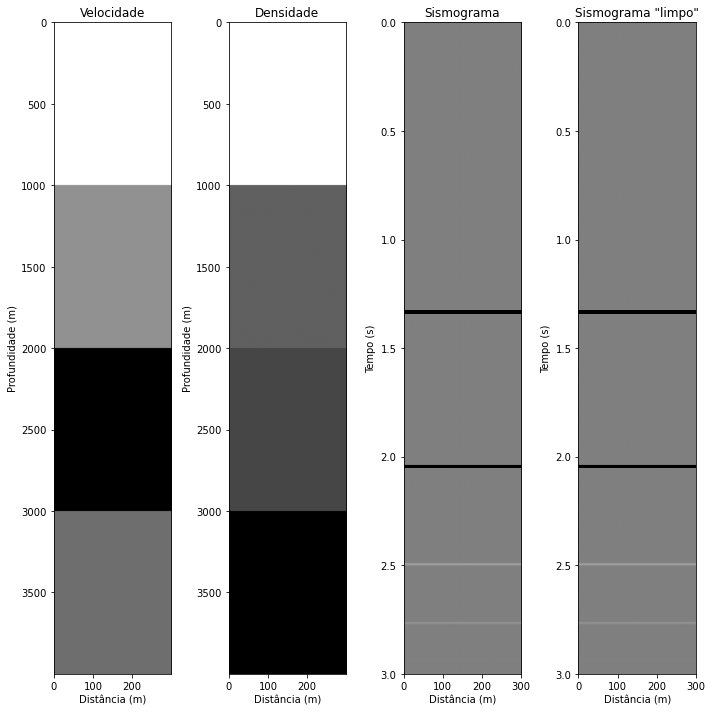

In [24]:
ModeloParalelas().plot()

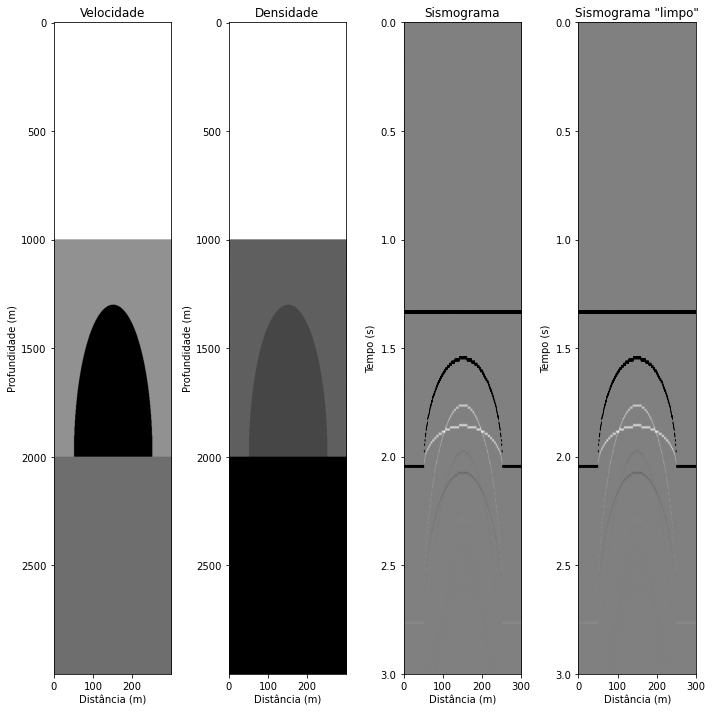

In [25]:
ModeloDomo().plot()

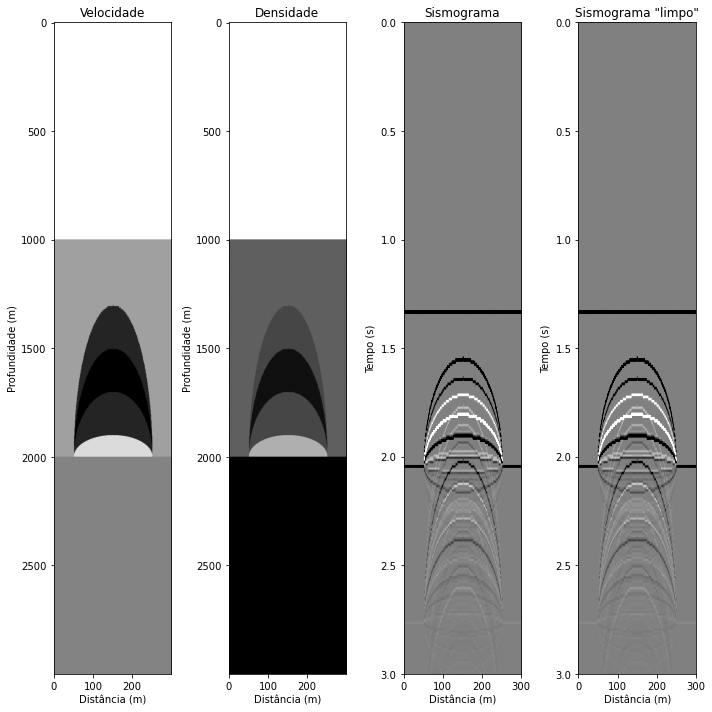

In [26]:
ModeloPreSal().plot()